## AirBnB Boston Dataset

### An analysis on price fluctuation

When looking at kernels developed by people on Kaggle, I noticed that the vast majority are focused on either predicting customer rating or price for a given property.   

Very little effort, however has been placed on explaining why some property prices do not adapt to demand. That is, some properties seem to have the same price for the whole year. Thus, these properties are at risk of either be overpriced for certain periods of time or underprice and so undermining competition.

It's in the interest of AirBnB to promote competition among it's customers so the final user can have the best value. Therefore in this notebook I'll try to answer the following three questions

- Do fluctuations in price tend to be randmonly distributed across properties?
- Are properties that adapt their prices more popular among AirBnB users?
- Can AirBnB somehow identify properties of each type so it can make recommendations?

In principle it makes sense to think that adjusting property prices to customer demand is linked to a more successful letting experience, so hopefully answering the questions above will corroborate this thought.

Let's first import all those modules that are required for this analysis

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

Having inspected the columns, it seems that some of them won't be relevant for this study, so let's drop those.
Additionally, price should be a number, not a string. Let's reformat that feature

In [25]:
df = pd.read_csv('listings.csv')
columnsToDelete = ['listing_url','scrape_id','last_scraped','summary','name','space','description',
                   'experiences_offered','neighborhood_overview','notes','transit','access','interaction',
                   'house_rules','thumbnail_url','medium_url','picture_url','xl_picture_url','host_url','host_name',
                   'host_since','host_location','host_about','host_thumbnail_url','host_picture_url','host_neighbourhood',
                   'host_verifications','city','state','market','smart_location','country_code','country','amenities',
                   'calendar_updated','calendar_last_scraped','first_review','last_review']
df_clean = df.drop(columns=columnsToDelete)
df_clean.loc[:,'price'] = df_clean.price.apply(lambda x: float(x[1:].replace(',','')))

With regards to price, it's not clear to me what does this price mean... as price tends to fluctuate depending on the time of the year, is this the average price for the property?

In [26]:
df_clean[['id','price']].head()

,id,price
0,12147973,250.0
1,3075044,65.0
2,6976,65.0
3,1436513,75.0
4,7651065,79.0


Let's use calendar.csv to find out what is the price for the whole data set and calculate some statistics. Then cross check with data in df_clean and see what price in df_clean corresponds to.

In [27]:
df2 = pd.read_csv('calendar.csv')
# Remove all rows that contain empty fields
df2_clean = df2.dropna()
# parse price column and convert it to a number
df2_clean.loc[:,'price'] = df2_clean.price.apply(lambda x: float(x[1:].replace(',','')))
# calculate some stats for each property by using describe method
df2_mod = df2_clean.groupby(['listing_id']).describe()
# Reformat the dataframe so we can then use it to concatenate it with the main dataframe
df2_mod.columns = df2_mod.columns.droplevel()
df2_mod = df2_mod.reset_index()
df_to_concat = df2_mod
# print some stats for verification purposes
df2_mod.head()

,listing_id,count,mean,std,min,25%,50%,75%,max
0,3353,249.0,35.204819,1.302222,32.0,35.0,36.0,36.0,36.0
1,5506,344.0,147.267442,17.043196,145.0,145.0,145.0,145.0,275.0
2,6695,324.0,197.407407,17.553300,195.0,195.0,195.0,195.0,325.0
3,6976,319.0,65.000000,0.000000,65.0,65.0,65.0,65.0,65.0
4,8792,248.0,154.000000,0.000000,154.0,154.0,154.0,154.0,154.0


It can be seen above that some properties are always offered to the market with the same price. I'm curious as to why this is the case so let's first check what is the distribution for some of the features above.

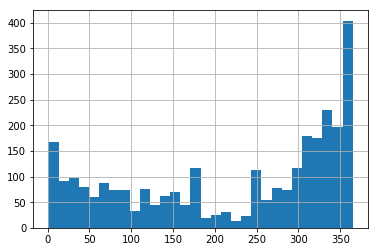

In [28]:
df2_mod['count'].hist(bins=30)

It seems that there are a fair amount of properties that are only offered to the market on certain occasions. It may well be that owners of these properties do actually live there and are renting them while they are on holiday, or under special occasions. This therefore would indicate why the price is always the same. If they are only advertised for a short period of time it is very likely that demand keeps constant throughout. Therefore there is no need to adjust the price of the property.

With this in mind, it makes sense to answer the first question to remove these properties are they would add a bias to the analysis.

**1 . Do fluctuations in price tend to be randmonly distributed across properties?**

Let's first check what is the distribution of the mean for property prices

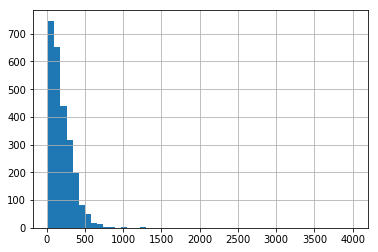

In [29]:
df2_mod.drop(df2_mod[df2_mod['count'] <= 40].index,inplace=True)
df2_mod['mean'].hist(bins=50)

Let's remove the price outliers as they are not representative of the whole population.    

Once the dataframe is clean, let's plot a heatmap where we plot standarized price variablity according to its price and how many days that property is on offer. This will help understand what are the properties that are more likely to adjust prices and whether there is any pattern in price variability.

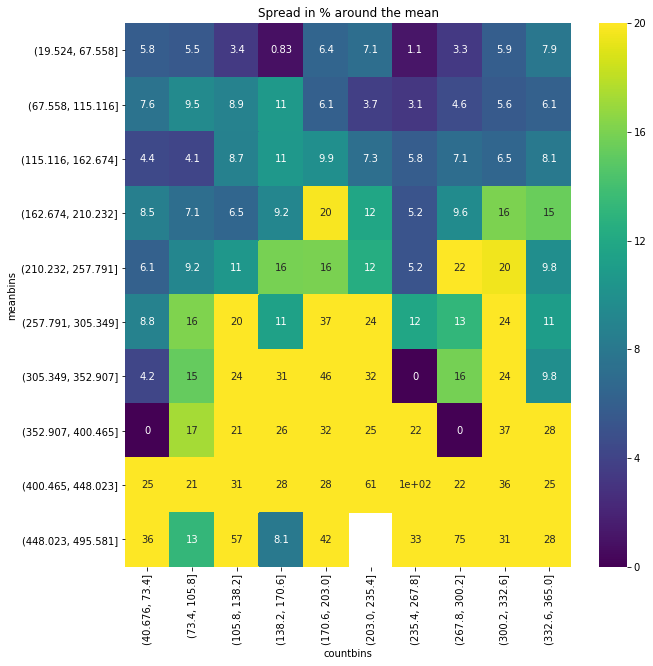

In [30]:
# Remove price outliers
df2_mod = df2_mod[(df2_mod['mean'] < 500)]
numbins = 10
# Prepare the dataframe to plot it using a heatmap
plt.figure(figsize=(10,10))
plt.title('Spread in % around the mean')
df2_mod['meanbins'] = pd.cut(df2_mod['mean'],numbins)
df2_mod['countbins'] = pd.cut(df2_mod['count'],numbins)
df2_mod['spread'] = (df2_mod['75%'] - df2_mod['25%'])/df2_mod['mean']*100
df2_heat = df2_mod[['meanbins','countbins','spread']].groupby(['meanbins','countbins']).mean().unstack()['spread']
sns.heatmap(df2_heat,vmax=20,cmap='viridis',annot=True);

Variability in prices don't seem to depend as much on the number of days offered to the market as it depends on the property value. In other words, variability in price seems to be more correlated with property value than it's correlated with number of days the property is available.

The only caveat to the statement above is that variablity in prices for those properties that are offered to the market less than 40 days hasn't been analysed.

This should come as no surprise, expensive properties are generally more scarce than cheaper ones, and so there is less competition and they can increase prices by a huge margin when there is a lot of demand. On the other hand cheaper properties face a stiff competition and so their margins are probably lower and so they cannot afford such big fluctuations in prices.

Therefore we can make a further split in our data, properties which have a mean price of less than 250 are considered average and face tougher competition. Properties above 250 are regarded as expensive and they can adjust their prices more freely. 

Let's add this information together with price information to the main dataframe. This engineered features may help us answer the following two questions

In [31]:
df_to_concat_2 = df_to_concat.rename(columns=lambda x: 'price_'+x)
df_to_concat_2['isExpensive'] = (df_to_concat_2['price_mean'] > 250).map({True:1,False:0})
df_to_concat_2['hasFluctuation'] = (df_to_concat_2['price_max'] - df_to_concat_2['price_min'] > 0).map({True:1,False:0})
df_clean = df_clean.merge(df_to_concat_2,how='left',left_on='id',right_on='price_listing_id').drop(columns='price_listing_id')
df_clean['hasFluctuation'] = df_clean['hasFluctuation'].fillna(0)
indexestoreplace = df_clean[df_clean['isExpensive'].isna()].index
df_clean.loc[indexestoreplace,'isExpensive'] = (df_clean[df_clean['isExpensive'].isna()]['price'] > 250).map({True:1,False:0})

**2 . Are properties that adapt their prices more popular among AirBnB users?**

To answer the second question, my idea is to carry out inference on the mean of feature *reviews_per_month*. By setting the right hypothesis and running the test I will be able to assess whether adjusting prices to demand leads to more lettings per month. 

However, first of all the dataset needs to be cleaned. So let's first "wrangle" the dataset and then conduct the study

In [32]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3585 entries, 0 to 3584
Data columns (total 67 columns):
id                                  3585 non-null int64
host_id                             3585 non-null int64
host_response_time                  3114 non-null object
host_response_rate                  3114 non-null object
host_acceptance_rate                3114 non-null object
host_is_superhost                   3585 non-null object
host_listings_count                 3585 non-null int64
host_total_listings_count           3585 non-null int64
host_has_profile_pic                3585 non-null object
host_identity_verified              3585 non-null object
street                              3585 non-null object
neighbourhood                       3042 non-null object
neighbourhood_cleansed              3585 non-null object
neighbourhood_group_cleansed        0 non-null float64
zipcode                             3547 non-null object
latitude                            3585 non

It seems that I can still delete some additional few columns.   
Also, impute some values for certain columns, drop some nans from others... the whole process in the snippet below

In [33]:
columnsToRemove = ['host_total_listings_count','street','host_id','neighbourhood_group_cleansed','neighbourhood','has_availability','zipcode','square_feet','weekly_price','monthly_price','license','jurisdiction_names']
df_clean.drop(columns=columnsToRemove,inplace=True)
df_clean.host_response_rate = df_clean.host_response_rate.fillna('0%').map(lambda x: str(x)[:-1])
df_clean.host_acceptance_rate = df_clean.host_acceptance_rate.fillna('0%').map(lambda x: str(x)[:-1])
df_clean.host_response_time = df_clean.host_response_time.fillna('a few days or more')
# if there are no review rating or reviews per month then i'm not interested in this row
df_clean.dropna(subset=['property_type','bathrooms','bedrooms','beds','review_scores_rating','reviews_per_month'],inplace=True)
df_clean.security_deposit = df_clean.security_deposit.fillna('$0').map(lambda x: int(x[1:].replace('.','').replace(',','')))/100
df_clean.cleaning_fee = df_clean.cleaning_fee.fillna('$0').map(lambda x: int(x[1:].replace('.','').replace(',','')))/100
indecesPrices = df_clean[df_clean['price_count'].isna()].index
df_clean['price_count'] = df_clean['price_count'].fillna(1)
df_clean.loc[indecesPrices,'price_mean'] = df_clean.loc[indecesPrices,'price']
df_clean['price_std'] = df_clean['price_std'].fillna(0)
df_clean.loc[indecesPrices,'price_min'] = df_clean.loc[indecesPrices,'price']
df_clean.loc[indecesPrices,'price_max'] = df_clean.loc[indecesPrices,'price']
df_clean.loc[indecesPrices,'price_25%'] = df_clean.loc[indecesPrices,'price']
df_clean.loc[indecesPrices,'price_50%'] = df_clean.loc[indecesPrices,'price']
df_clean.loc[indecesPrices,'price_75%'] = df_clean.loc[indecesPrices,'price']

df_clean.review_scores_accuracy.fillna(df_clean.review_scores_accuracy.mean(),inplace=True)
df_clean.review_scores_cleanliness.fillna(df_clean.review_scores_cleanliness.mean(),inplace=True)
df_clean.review_scores_checkin.fillna(df_clean.review_scores_checkin.mean(),inplace=True)
df_clean.review_scores_communication.fillna(df_clean.review_scores_communication.mean(),inplace=True)
df_clean.review_scores_value.fillna(df_clean.review_scores_value.mean(),inplace=True)
df_clean.review_scores_location.fillna(df_clean.review_scores_location.mean(),inplace=True)
# one hot encode and types of columns
df_clean.host_response_rate = df_clean.host_response_rate.astype(float)
df_clean.host_acceptance_rate = df_clean.host_acceptance_rate.astype(float)
df_clean.extra_people = df_clean.extra_people.map(lambda x: int(x[1:].replace('.','').replace(',','')))/100
cat_df = df_clean.select_dtypes(include=['object'])
df_ready = pd.get_dummies(data=df_clean, prefix_sep='_',columns=cat_df.columns, drop_first=True, dummy_na=False)

Let's do some basic plots on the numerical values, to get an idea on what kind of distributions I'm dealing with

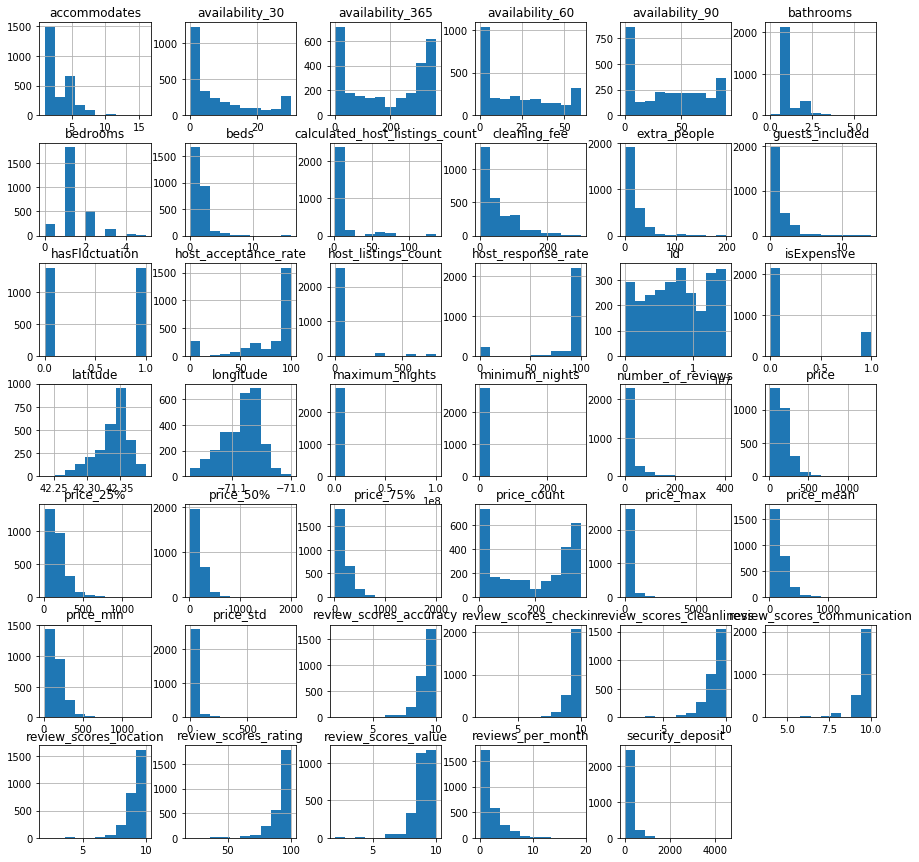

In [34]:
df_ready[[c for c in df_ready.columns if c not in df_ready.select_dtypes(include=['uint8']).columns]].hist(figsize=(15,15));

Also, get an idea of how different features correlate to one another

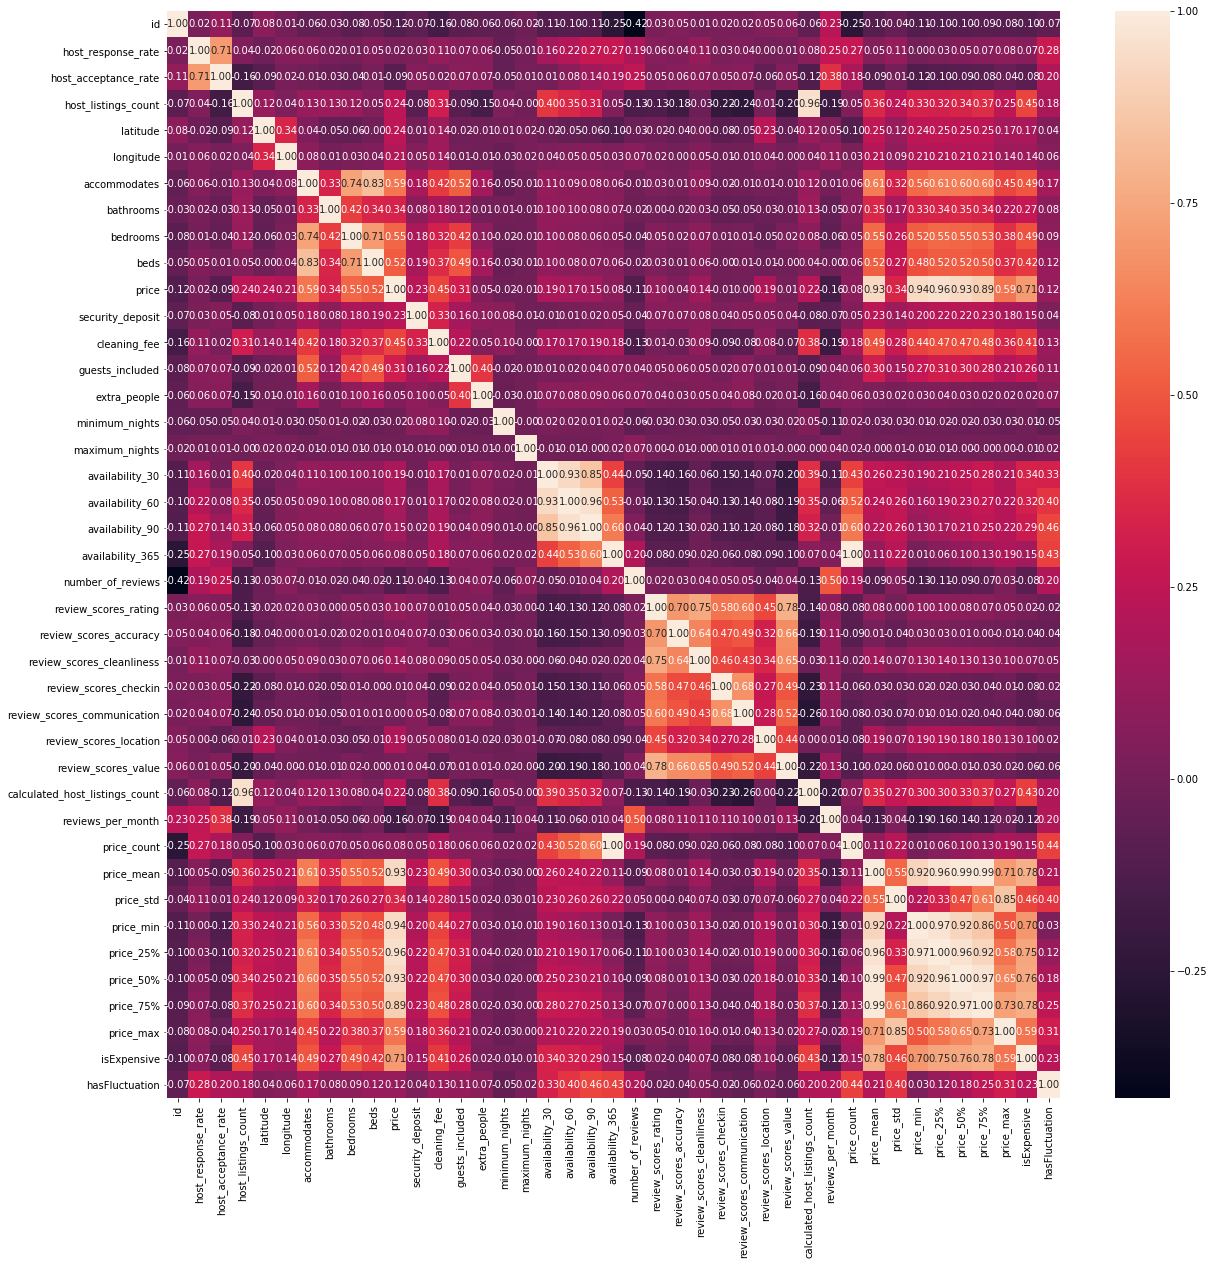

In [35]:
plt.figure(figsize=(20,20))
sns.heatmap(df_ready[[c for c in df_ready.columns if c not in df_ready.select_dtypes(include=['uint8']).columns]].corr(), annot=True, fmt=".2f");

There are two assumptions I made to answer this question.

First is that the feature that indicates the number of reviews received per month correlates to how many days the property has been occupied for that month. Therefore a higher number of reviews will suggest that the property has been used more than if that number was smaller

Second is that the average length of days of any letting per any single booking is the same for both groups.

The reason for making these assumptions is that there is no other way in which this information can be inferred from the data. However I think this are fair assumptions to make

Then we need to create these two groups under analysis. On the one hand those properties that see no fluctuation in their prices and are offered to the market more than 40 days. On the other hand those properties that experience fluctuation on their prices and again are offered more than 40 days

To conduct this study, the null hypothesis is that the difference in means between this two groups is 0. Let's therefore verify that this is the case by running this simple experiment

In [36]:
# Note that 40 days was the previous threshold chosen for a house not to be rented only on vacation periods
df_fluct = df_ready[ (df_ready['hasFluctuation'] == 1)  & (df_ready['price_count'] > 40)]
df_nofluct = df_ready[(df_ready['hasFluctuation'] == 0) & (df_ready['price_count'] > 40)]
df_fluct.shape, df_nofluct.shape

((1376, 95), (639, 95))

Let's see now what are the difference in their mean for "reviews_per_month"

2.4430959302325617


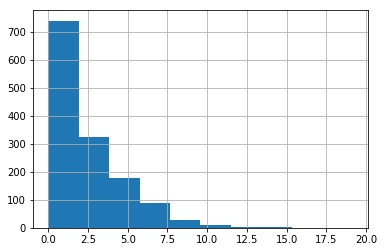

In [37]:
print(df_fluct['reviews_per_month'].mean())
df_fluct['reviews_per_month'].hist();

1.5491549295774636


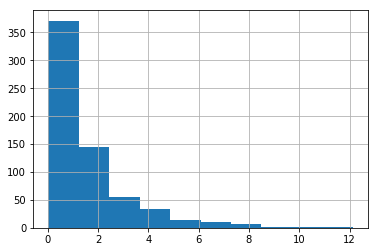

In [38]:
print(df_nofluct['reviews_per_month'].mean())
df_nofluct['reviews_per_month'].hist();

The difference is approx 0.9 reviews per month difference. So it seems that those properties that experience fluctuation in their prices on average are booked more often. Note that this is the case for this dataset. In general this cannot be stated unless we carry out the inference on the difference in means.   

Let's apply some boostrapping (10k iterations) on these dataset and calculate the sample distribution of the sample means. The sampling distribution of the sampling mean (central limit theorem) is given by a normal distribution.

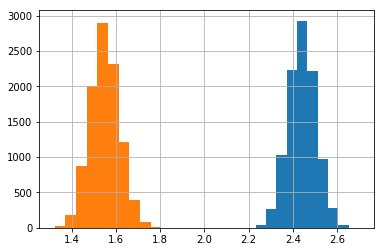

In [39]:
np.random.seed(42)
fluctmeans = []
nofluctmeans = []
meandif = []
for _ in range(10000):
    meanfluct = df_fluct.sample(df_fluct.shape[0],replace=True).reviews_per_month.mean()
    meannofluct = df_nofluct.sample(df_nofluct.shape[0],replace=True).reviews_per_month.mean()
    fluctmeans.append(meanfluct)
    nofluctmeans.append(meannofluct)
    meandif.append(meanfluct - meannofluct)
plt.hist(fluctmeans);
plt.hist(nofluctmeans);
plt.grid()
#plt.hist(meandif);stdmeandiff = meandif.std()

Given the normal distributions above, it seems clear that the difference in the number of reviews observed in the dataset between these two datasets is real. Let's plot the distribution under the null hypothesis

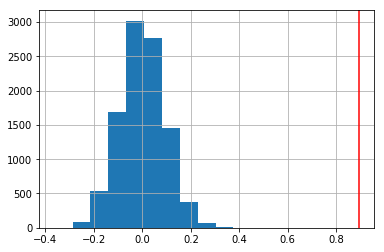

In [40]:
#stdmeandiff = np.asarray(meandif).std()
normaldist = np.random.normal(0, np.std(meandif), 10000);
plt.hist(normaldist);
plt.axvline(x=(df_fluct['reviews_per_month'].mean() - df_nofluct['reviews_per_month'].mean()),c='r')
plt.grid()

Given the above analysis we can reject the null hypothesis as there is statistical evidence to claim that on average people that adapt the prices for their properties based on demand are more likely to high a higher occupancy rate than those that don't.

It seems therefore that property owners are better off by adjusting prices to demand along the year.

**3 . Can AirBnB somehow identify properties of each type so it can make recommendations?**

Given the answer for the second question, then it seems relevant that AirBnB wants to find out what are the differences in characteristics between those properties that adjust prices and those that don't. 

Let's therefore build an ML classifier model to predict wehther a new property owner will fall under the category of price adjusting or not. If the latter, then AirBnB can get in contact with that person and let him know about this study.

The idea is creating an ML model that is capable of somehow assign importance to all features. In this case, I have decided to create a logistic regression and a random forest models. Since the way they minimize the loss function is different they are likely to give different results for the importance of features. However we can combine both to get a better idea on what features are more relevante when it comes to identify a customer that may not be very well informed.

Remember that before we made a distinction between properties that were offered less than 40 days a year and those that were offered to the market for more than that. By running models including both types or only the second, I will be able to spot differences between these two groups of properties as well.

Let's first create a function that will be common for both situations describe above

In [41]:
def featSelectionTwoModels(df,coldrop,colpred,numfeatures):
    # drop the columns that are not important for this analysis
    dfml = df.drop(columns=coldrop)
    # scaling is not necessary for random forest, but it's for logistic regression, so scale the 
    # numerical features
    dfscaled = pd.DataFrame(np.concatenate([StandardScaler().fit_transform(dfml.iloc[:,:27]),dfml.iloc[:,27:] ],axis=1),columns=dfml.columns)
    dfscaledpos = dfscaled[dfscaled[colpred] == 1]
    # Check wehtehr the data set is too unbalance. 
    measbalance= dfscaledpos.shape[0]/dfscaled.shape[0]
    print('Measure of balance: {}. dataset shape: {}'.format(measbalance,dfscaled.shape))
    # If unbalanced, then correct it a bit by downsampling
    if (measbalance > 0.65):
        numrowstoremove = int(dfscaled.shape[0] * (2*(measbalance-0.05) - 1))
        rowstoremove= dfscaledpos.sample(numrowstoremove).index
        dfscaled.drop(rowstoremove,inplace=True)
        dfscaledpos = dfscaled[dfscaled[colpred] == 1]
        measbalance= dfscaledpos.shape[0]/dfscaled.shape[0]
        print('New Measure of balance (after downsampling): {}. dataset shape: {}'.format(measbalance,dfscaled.shape))
    # Split in dependent and independent
    X,y = dfscaled.drop(columns=colpred), dfscaled[colpred]
    # Further split in train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state=42)
    # Train and calculate accuracy for random forest.
    modelRF = RandomForestClassifier(n_estimators=300)
    modelRF.fit(X_train,y_train)
    ypredRF = modelRF.predict(X_test)
    print('Accuracy score on test set random forest: {}'.format(accuracy_score(y_test,ypredRF)))
    # Train and metrics for logistic regression with ridge regularization
    modelLR = LogisticRegression(penalty='l2')
    modelLR.fit(X_train,y_train)
    ypredLR = modelLR.predict(X_test)
    print('Accuracy score on test set logistic regression: {}'.format(accuracy_score(y_test,ypredLR)))
    print()
    # Get the most important features and return a list for each model back.
    mylist1 =[]
    print('List of important features for Random Forest')
    for c,f in zip(X.columns,modelRF.feature_importances_):
        mylist1.append((c,f))
    for fea,score in sorted(mylist1,key=lambda x: x[1],reverse=True)[:numfeatures]:
        print('{}: {}'.format(fea,score))
    mylist2 =[]
    print()
    print('List of important features for Logistic Regression')
    for c,f in zip(X.columns,modelLR.coef_[0]):
        mylist2.append((c,f))
    for fea,score in sorted(mylist2,key=lambda x: abs(x[1]),reverse=True)[:numfeatures]:
        print('{}: {}'.format(fea,score))
    return mylist1, mylist2

Measure of balance: 0.5005456529647144. dataset shape: (2749, 83)
Accuracy score on test set random forest: 0.8327272727272728
Accuracy score on test set logistic regression: 0.7472727272727273

List of important features for Random Forest
availability_365: 0.2315273102887163
reviews_per_month: 0.05513760920400384
number_of_reviews: 0.04678381720946883
host_listings_count: 0.04194622274465787
calculated_host_listings_count: 0.04083997995251284
host_acceptance_rate: 0.040453439014158425
latitude: 0.03877106810819909
cleaning_fee: 0.038111723736769576
price: 0.03791145445412483
longitude: 0.03602149694821155

List of important features for Logistic Regression
availability_365: 1.0636289926450457
isExpensive: 0.8902977795825177
neighbourhood_cleansed_Longwood Medical Area: -0.8673509720749212
cancellation_policy_strict: 0.7486113333676617
minimum_nights: -0.7181240586471609
neighbourhood_cleansed_Mattapan: -0.7102677200085188
neighbourhood_cleansed_East Boston: -0.6965126430847709
cancell

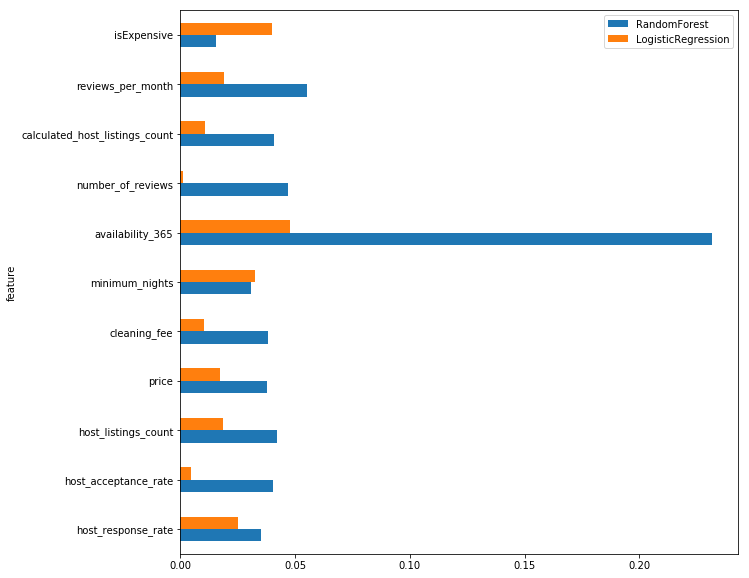

In [42]:
dropcols= ['id','price_std','price_mean','price_count','price_25%','price_50%','price_75%','price_min','price_max','availability_30','availability_60','availability_90']
rf,lr = featSelectionTwoModels(df_ready,dropcols,'hasFluctuation',10)
results = pd.DataFrame(rf,columns=['feature','RandomForest']).set_index('feature')
results['LogisticRegression'] = [value for _,value in lr]
results['LogisticRegression'] = abs(results['LogisticRegression'])/abs(results['LogisticRegression']).sum()
results['RandomForest'] = abs(results['RandomForest'])/abs(results['RandomForest']).sum()
thresholdboth = 1/100
thresholdany = 4/100
results.drop(results[((results['LogisticRegression'] < thresholdboth) | (results['RandomForest'] < thresholdboth)) & (results['LogisticRegression'] < thresholdany)& (results['RandomForest'] < thresholdany) ].index, inplace=True)
results.plot(kind='barh',figsize=(10,10))

Measure of balance: 0.68287841191067. dataset shape: (2015, 83)
New Measure of balance (after downsampling): 0.5682432432432433. dataset shape: (1480, 83)
Accuracy score on test set random forest: 0.7128378378378378
Accuracy score on test set logistic regression: 0.6621621621621622

List of important features for Random Forest
reviews_per_month: 0.0674564617728922
latitude: 0.056435125531069656
minimum_nights: 0.055489874874850395
longitude: 0.05239543626525521
cleaning_fee: 0.05138442679806135
availability_365: 0.049233066039161576
price: 0.04898381825252147
number_of_reviews: 0.047971325858255025
host_listings_count: 0.04419371999368139
calculated_host_listings_count: 0.03877957409760198

List of important features for Logistic Regression
host_listings_count: 1.255654306396005
neighbourhood_cleansed_Charlestown: -1.1662642273764092
property_type_Boat: -1.0401644079501666
cancellation_policy_strict: 0.9841695767182521
neighbourhood_cleansed_East Boston: -0.878662573501558
minimum_nigh

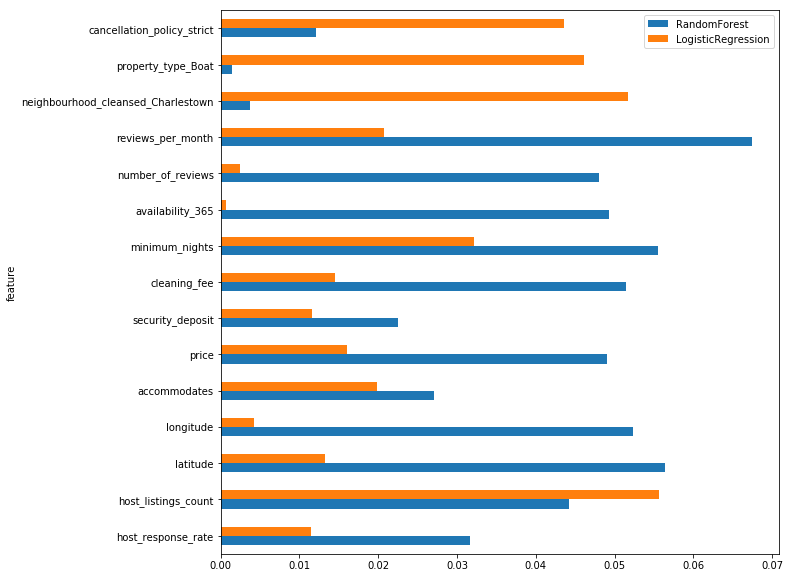

In [43]:
dropcols= ['id','price_std','price_mean','price_count','price_25%','price_50%','price_75%','price_min','price_max','availability_30','availability_60','availability_90']
rf,lr =featSelectionTwoModels(df_ready[df_ready['price_count'] > 40],dropcols,'hasFluctuation',10)
results = pd.DataFrame(rf,columns=['feature','RandomForest']).set_index('feature')
results['LogisticRegression'] = [value for _,value in lr]
results['LogisticRegression'] = abs(results['LogisticRegression'])/abs(results['LogisticRegression']).sum()
results['RandomForest'] = abs(results['RandomForest'])/abs(results['RandomForest']).sum()
thresholdboth = 1/100
thresholdany = 4/100
results.drop(results[((results['LogisticRegression'] < thresholdboth) | (results['RandomForest'] < thresholdboth)) & (results['LogisticRegression'] < thresholdany)& (results['RandomForest'] < thresholdany) ].index, inplace=True)
results.plot(kind='barh',figsize=(10,10))

Given the results above the first conclusion that can be drawn is connected with the first question. Recall that properties that were on offer less than 40 days were discarded from the analysis. This was due to the fact that it was thought they may offer the same price or at least they would be outliers when compared to the rest of  the properties. This is confirmed by feature importance compared between the first set of models and the second. In the first set of models we can see that the most important feature for both models when it comes to differentiate between properties that adjust prices and those that don't is **availability_365** whereas in the second this is not the case.

This leads me to think that those properties that are on offer for less than 40 days are making those models give priority to availability and so availability is a very important feature for those properties that are available for a few days only.

Now focusing only on results for the second set of models. The last plot shows all  those features that account for more than 1% importance in both models or account for more than 4% importance in any single model. It is visible that there are some discrepancies between models, but since random forest offers better accuracy I'll give more relevance to thos features

Interestingly, reviews_per_month is a good predictor in both models. This finding corroborates the answer given for the second question. Therefore it seems clear that reviews_per_month and price adjustment are well connected.

Host_listing_count seems to be also an important feature. My take on this is that people offering a few properties are well aware of the fact that adjusting prices is necessary and so they are very likely to adjust prices.

Minimum_nights looks important on both models. By looking at the sign of the coefficient for logistic regression we can see that this is negative. This suggests that properties where minimun number of nights is high are more likely to leave their prices unchanged. I'm thinking that this is the case of those properties that are booked while the owners are on holiday. So if they go for a week on holiday, they may not be willing to accept guests that are going to stay only for one or two days as they won't be at home to get it cleaned and ready for the following guest.

Lastly, price seems to be connected with price adjustment too. Again by looking at the sign of the associated coefficient in the linear regression model I can see that it suggests that the higher the price for a property, the more it's likely to adjust the price. Answer for question number 1 again comes in handy to complement this finding as it was seen that the more expensive the property the bigger the variability in price